# Start Here

In [ ]:
pip install gym[toy_text]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 85.4 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.1
    Uninstalling pygame-2.5.1:
      Successfully uninstalled pygame-2.5.1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 120831 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../3-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselected package xfonts-encodings.
Preparing to unpack .../4-xfonts-encodings_1%3a1.0.5-0ubuntu2_all.deb ...
Unpacking xfonts-encodings (1:1.0.5-0ubuntu2) ...
Selecting previously unselected package xfonts-util

In [ ]:
!git clone https://github.com/openai/gym.git

Cloning into 'gym'...
remote: Enumerating objects: 16503, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 16503 (delta 2), reused 2 (delta 0), pack-reused 16497
Receiving objects: 100% (16503/16503), 6.94 MiB | 21.04 MiB/s, done.
Resolving deltas: 100% (11625/11625), done.


In [ ]:
# change name gym folder to gyms
from gyms.gym.envs.toy_text import frozen_lake
from gyms.gym.envs.toy_text.frozen_lake import generate_random_map

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment CartPole-v0
  logger.warn(f"Overriding environment {spec.id}")
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment CartPole-v1
  logger.warn(f"Overriding environment {spec.id}")
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment MountainCar-v0
  logger.warn(f"Overriding environment {spec.id}")
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment MountainCarContinuous-v0
  logger.warn(f"Overriding environment {spec.id}")
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment Pendulum-v1
  logger.warn(f"Overriding environment {spec.id}")
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environme

# TEST ENVIRONMENT

In [ ]:
# from
env = frozen_lake.FrozenLakeEnv(is_slippery=False, desc=["SFFF", "FHFF", "FFFF", "FFFG"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env.reset()

(0, {'prob': 1})

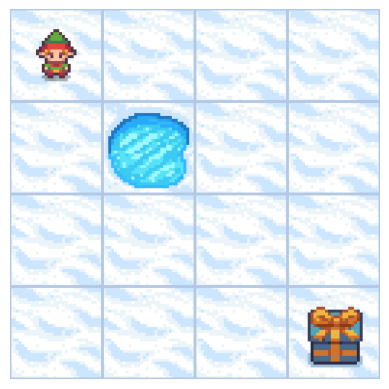

In [ ]:
plt.imshow(env._render_gui('rgb_array'));
plt.axis('off');

(5, 0.0, True, False, {'prob': 1.0})
Observation space: Discrete(16)
Action space: Discrete(4)


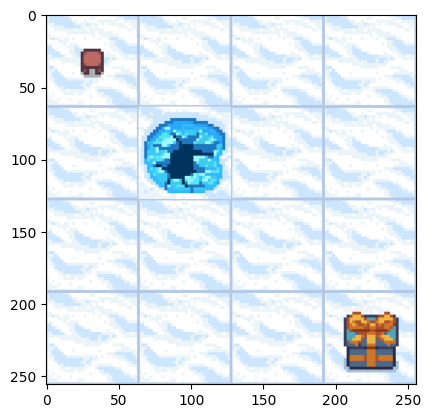

In [ ]:
a = env.step(1)
plt.imshow(env._render_gui('rgb_array'))
print(a)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

In [ ]:
env.action_space

Discrete(4)

In [ ]:
li = env.P[2][3]
li

[(1.0, 2, 0.0, False)]

In [ ]:
li.append((1.0, 3, 0, True))
li

[(1.0, 3, 0.0, False), (1.0, 3, 0, True)]

# **Actor Critic Test**

In [ ]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo/actor'):
        super(ActorNetwork, self).__init__()

        self.chkpt_dir = chkpt_dir

        # self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')

        self.actor = nn.Sequential(
                nn.Linear(input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)

        return dist

    def save_checkpoint(self, file_name='actor.pth'):
        model_folder_path = self.chkpt_dir
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        T.save(self.state_dict(), file_name)

    def load_checkpoint(self, file_name='actor.pth'):

        file_name = os.path.join(self.chkpt_dir, file_name)
        self.load_state_dict(T.load(file_name))


    # def save_checkpoint(self):
    #     T.save(self.state_dict(), self.checkpoint_file)

    # def load_checkpoint(self):
    #     self.load_state_dict(T.load(self.checkpoint_file))

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='tmp/ppo/critic'):
        super(CriticNetwork, self).__init__()

        self.chkpt_dir = chkpt_dir
        # self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                nn.Linear(input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint(self, file_name='critic.pth'):
        model_folder_path = self.chkpt_dir
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        T.save(self.state_dict(), file_name)

    def load_checkpoint(self, file_name='critic.pth'):

        file_name = os.path.join(self.chkpt_dir, file_name)
        self.load_state_dict(T.load(file_name))

    # def save_checkpoint(self):
    #     T.save(self.state_dict(), self.checkpoint_file)

    # def load_checkpoint(self):
    #     self.load_state_dict(T.load(self.checkpoint_file))

class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)

    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)

            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

In [ ]:
env.action_space.n

4

episode 0 score 0.0 avg score 0.0 time_steps 17 learning_steps 3
episode 1 score 0.0 avg score 0.0 time_steps 19 learning_steps 3
... saving models ...
episode 2 score 1.0 avg score 0.3 time_steps 35 learning_steps 7
episode 3 score 0.0 avg score 0.2 time_steps 37 learning_steps 7
episode 4 score 0.0 avg score 0.2 time_steps 39 learning_steps 7
episode 5 score 0.0 avg score 0.2 time_steps 51 learning_steps 10
episode 6 score 0.0 avg score 0.1 time_steps 86 learning_steps 17
episode 7 score 0.0 avg score 0.1 time_steps 92 learning_steps 18
episode 8 score 1.0 avg score 0.2 time_steps 104 learning_steps 20
episode 9 score 0.0 avg score 0.2 time_steps 108 learning_steps 21
episode 10 score 0.0 avg score 0.2 time_steps 111 learning_steps 22
episode 11 score 0.0 avg score 0.2 time_steps 115 learning_steps 23
episode 12 score 0.0 avg score 0.2 time_steps 117 learning_steps 23
episode 13 score 0.0 avg score 0.1 time_steps 121 learning_steps 24
episode 14 score 1.0 avg score 0.2 time_steps 136

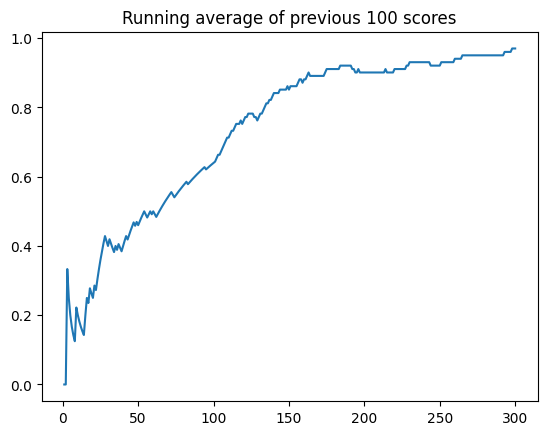

In [ ]:
if __name__ == '__main__':
    env = env = frozen_lake.FrozenLakeEnv(is_slippery=False, desc=["SFFF", "FHFF", "FFFF", "FFFG"])
    N = 5
    batch_size = 5
    n_epochs = 4
    alpha = 0.0003
    agent = Agent(n_actions=env.action_space.n, batch_size=batch_size,
                    alpha=alpha, n_epochs=n_epochs,
                    input_dims=env.observation_space.n)
    n_games = 300

    figure_file = 'plots/cartpole.png'

    best_score = env.reward_range[0]
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0

    for i in range(n_games):
        observation = env.reset()[0]
        observation = get_state(observation) # EDITED
        done = False
        score = 0
        while not done:
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done, info, _ = env.step(action)
            observation_ = get_state(observation_) # EDITED
            n_steps += 1
            score += reward
            agent.remember(observation, action, prob, val, reward, done)
            if n_steps % N == 0:
                agent.learn()
                learn_iters += 1
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()

        print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
                'time_steps', n_steps, 'learning_steps', learn_iters)
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file)

In [ ]:
 observation_, reward, done, info = env.step(3)

ValueError: ignored

# Ends Here

# A3C TEST

In [ ]:
def get_state(state):

  state_arr = np.zeros(env_id.observation_space.n)
  state_arr[state] = 1
  state= np.reshape(state_arr, [1, env_id.observation_space.n])
  return state

# state = env.reset()[0]
# state = get_state(state)
# state

In [ ]:
# from envi import *
import torch as T
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

N_GAMES = 3000000000000
T_MAX = 5


class SharedAdam(T.optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8,
            weight_decay=0):
        super(SharedAdam, self).__init__(params, lr=lr, betas=betas, eps=eps,
                weight_decay=weight_decay)

        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = 0
                state['exp_avg'] = T.zeros_like(p.data)
                state['exp_avg_sq'] = T.zeros_like(p.data)

                state['exp_avg'].share_memory_()
                state['exp_avg_sq'].share_memory_()

class ActorCritic(nn.Module):
    def __init__(self, input_dims, n_actions, gamma=0.99):
        super(ActorCritic, self).__init__()

        self.gamma = gamma

        self.pi1 = nn.Linear(input_dims, 128)
        self.pi2 = nn.Linear(128, 256)
        self.pi3 = nn.Linear(256, 128)
        self.pi4 = nn.Linear(128, 64)

        self.v1 = nn.Linear(input_dims, 128)
        self.v2 = nn.Linear(128, 256)
        self.v3 = nn.Linear(256, 128)
        self.v4 = nn.Linear(128, 64)

        self.pi = nn.Linear(64, n_actions)
        self.v = nn.Linear(64, 1)

        self.rewards = []
        self.actions = []
        self.states = []

    def remember(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def clear_memory(self):
        self.states = []
        self.actions = []
        self.rewards = []

    def forward(self, state):
        # print('\nstate: ', state)
        pi1 = F.relu(self.pi1(state))
        pi2 = F.relu(self.pi2(pi1))
        pi3 = F.relu(self.pi3(pi2))
        pi4 = F.relu(self.pi4(pi3))

        v1 = F.relu(self.v1(state))
        v2 = F.relu(self.v2(v1))
        v3 = F.relu(self.v3(v2))
        v4 = F.relu(self.v4(v3))

        pi = self.pi(pi4)
        v = self.v(v4)

        return pi, v

    def calc_R(self, done):
        states = T.tensor(self.states, dtype=T.float)
        _, v = self.forward(states)

        R = v[-1]*(1-int(done))

        batch_return = []
        for reward in self.rewards[::-1]:
            R = reward + self.gamma*R
            batch_return.append(R)
        batch_return.reverse()
        batch_return = T.tensor(batch_return, dtype=T.float)

        return batch_return

    def calc_loss(self, done):
        states = T.tensor(self.states, dtype=T.float)
        # print(self.actions)
        actions = T.tensor(self.actions, dtype=T.float)

        returns = self.calc_R(done)

        pi, values = self.forward(states)
        values = values.squeeze()
        critic_loss = (returns-values)**2

        probs = T.softmax(pi, dim=1)
        dist = Categorical(probs)
        log_probs = dist.log_prob(actions)
        actor_loss = -log_probs*(returns-values)

        total_loss = (critic_loss + actor_loss).mean()

        return total_loss

    def choose_action(self, observation):
        print(observation[0])
        state = T.tensor(observation[0], dtype=T.float)
        pi, v = self.forward(state)
        # print(pi.shape)
        probs = T.softmax(pi, dim=0)
        # print(probs)
        dist = Categorical(probs)
        # print(dist)
        action = dist.sample().item()
        print('action: ',action)

        return action

class Agent(mp.Process):
    def __init__(self, global_actor_critic, optimizer, input_dims, n_actions,
                gamma, lr, name, global_ep_idx, env_id):
        super(Agent, self).__init__()
        self.local_actor_critic = ActorCritic(input_dims, n_actions, gamma)
        self.global_actor_critic = global_actor_critic
        self.name = 'w%02i' % name
        self.episode_idx = global_ep_idx
        self.env = frozen_lake.FrozenLakeEnv(is_slippery=False, desc=["SFFF", "FHFF", "FFFF", "FFFG"])
        self.optimizer = optimizer

    def save_model(self, path):
        T.save(self.local_actor_critic.state_dict(), path)

    def load_model(self, path):
        self.local_actor_critic.load_state_dict(T.load(path))

    def run(self):
        t_step = 1
        while self.episode_idx.value < N_GAMES:
        #     if self.episode_idx.value % 5000 == 0 & self.episode_idx.value != 0:
        #         model_path = 'a3c_model/'
        #         model_path = model_path + 'a3c_' + str(self.episode_idx.value) + '.pth'
        #         self.save_model(model_path)

            # self.load_model(model_path)

            done = False
            observation = self.env.reset()[0]
            observation = get_state(observation)
            # print('focus HERE',observation)

            score = 0
            self.local_actor_critic.clear_memory()
            while not done:
                action = self.local_actor_critic.choose_action(observation)
                # print('action: ',action)
                x = self.env.step(action)
                # print(x)
                observation_, reward, done, info, _ = x
                # print('\n------observation--------: ',observation_)
                # print('type: ',type(observation_))

                observation_ = get_state(observation_) # EDITED
                # print('\nobservation_: ',observation_)

                score += reward
                self.local_actor_critic.remember(observation, action, reward)
                if t_step % T_MAX == 0 or done:
                    loss = self.local_actor_critic.calc_loss(done)
                    self.optimizer.zero_grad()
                    loss.backward()
                    for local_param, global_param in zip(
                            self.local_actor_critic.parameters(),
                            self.global_actor_critic.parameters()):
                        global_param._grad = local_param.grad
                    self.optimizer.step()
                    self.local_actor_critic.load_state_dict(
                            self.global_actor_critic.state_dict())
                    self.local_actor_critic.clear_memory()
                t_step += 1
                observation = observation_
                # print('\n-----state-------------- ',observation_)
            with self.episode_idx.get_lock():
                self.episode_idx.value += 1
            print(self.name, 'episode ', self.episode_idx.value, 'reward %.1f' % score)

if __name__ == '__main__':
    lr = 1e-4
    env_id = frozen_lake.FrozenLakeEnv(is_slippery=False, desc=["SFFF", "FHFF", "FFFF", "FFFG"])
    n_actions = env_id.action_space.n
    input_dims = env_id.observation_space.n

    global_actor_critic = ActorCritic(input_dims, n_actions)
    global_actor_critic.share_memory()
    optim = SharedAdam(global_actor_critic.parameters(), lr=lr,
                        betas=(0.92, 0.999))
    global_ep = mp.Value('i', 0)

    workers = [Agent(global_actor_critic,
                    optim,
                    input_dims,
                    n_actions,
                    gamma=0.99,
                    lr=lr,
                    name=i,
                    global_ep_idx=global_ep,
                    env_id=env_id) for i in range(mp.cpu_count())]
    [w.start() for w in workers]
    [w.join() for w in workers]

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
action: action:   22

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.][0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

action: action:   11



<ipython-input-7-f809b3367c2a>:94: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  states = T.tensor(self.states, dtype=T.float)
<ipython-input-7-f809b3367c2a>:94: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  states = T.tensor(self.states, dtype=T.float)
Process w00:
Process w01:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "<ipython-input-7-f809b

In [ ]:
print(env.step(1))

(15, 0, True, False, {'prob': 1.0})
